# Intro to Python - Part 3

## Outline

- Pandas
    - Construct DataFrames
    - Selection
    - Setting a new column
    - Operations
    - Grouping
    - Plot data
    - Read and save DataFrames

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(42)

`Pandas` is a data analysis toolkit for Python that makes it easy to work with certain types of data. We will illustrate how to use this pakcage from an event-study example.

Consider a setting in which 50 states in the US implemented a policy change at 4 different times. The states were sorted into treatment groups depending on when they implemented the policy.

We have the following data generation process:
1. Initiate a panel data set of 50 states x 30 years.
    - state $\in \{1,2,\ldots, 50\}$
    - year $\in \{1981, 1982, \ldots 2020\}$
2. Randomly assign each state into one of 4 treatment groups $g \in \{1986, 1992, 1998, 2004\}$.
3. For each observation, generate outcome following $$Y_{it} = (2010-g) + \alpha_i + \alpha_t + \tau_{it} + \epsilon_{it}$$
    - $\alpha_i \sim Normal(state/5, 1)$: unit fixed effects
    - $\alpha_t \sim Normal(0.1 * (t-g), 1)$: time fixed effects
    - $\epsilon_{it} \sim N(0, 1/4)$: idiosyncratic error
    - $\tau_{it} = 1 \times (t-g+1) \times \mathbb{1}(t \geq g)$: unit-specific treatment effects at time $t$.
    
Note that this is a classical staggered difference-in-differences setting that is discussed in Callaway and Sant'Anna (2021), Goodman-Bacon (2021), and Sun and Abraham (2021). Under this setting, TWFE will not obtain the treatment effect that we want.

## Construct a Pandas DataFrame

The `pandas.DataFrame` is a dataset object that we will mainly use for data analysis. We can construct a `pandas.DataFrame` using a dictionary where the column names are keys and lists of data are values.

In [3]:
states = list(range(1, 51)) * 30
years = np.repeat(list(range(1981, 2011)), 50)
treatment = list(np.random.choice([1986, 1992, 1998, 2004], 50)) * 30
data_dict = {
    "state": states,
    "year": years,
    "group": treatment
}
df = pd.DataFrame(data_dict)
df

,state,year,group
0,1,1981,1998
1,2,1981,1992
2,3,1981,1998
3,4,1981,2004
4,5,1981,1998
...,...,...,...
1495,46,2010,1992
1496,47,2010,1992
1497,48,2010,2004
1498,49,2010,1992


In [4]:
df.dtypes

state    int64
year     int32
group    int32
dtype: object

## Selection

We can extract data for a specific column (or columns):

In [10]:
df["state"]

0        1
1        2
2        3
3        4
4        5
        ..
1495    46
1496    47
1497    48
1498    49
1499    50
Name: state, Length: 1500, dtype: int64

In [12]:
df[["state", "year"]]

,state,year
0,1,1981
1,2,1981
2,3,1981
3,4,1981
4,5,1981
...,...,...
1495,46,2010
1496,47,2010
1497,48,2010
1498,49,2010


We can select via the position index:

In [15]:
df.iloc[0]

state       1
year     1981
group    1998
Name: 0, dtype: int64

In [16]:
df.iloc[100:105, 0:2]

,state,year
100,1,1983
101,2,1983
102,3,1983
103,4,1983
104,5,1983


We can select data based on boolean expressions:

In [17]:
df.loc[(df["state"] == 1) & (df["year"] < 1990), ["state", "year"]]

,state,year
0,1,1981
50,1,1982
100,1,1983
150,1,1984
200,1,1985
250,1,1986
300,1,1987
350,1,1988
400,1,1989


## Setting a new column

Setting by assigning with a NumPy array: 
- $\epsilon_{it} \sim N(0, 0.5^2)$

In [18]:
df["epsilon_it"] = np.random.normal(0, 0.5, len(df))

Setting by assigning combinations of other columns: 
- $\tau_{it} = 1 \times (t-g+1) \times \mathbb{1}(t - g \geq 0)$

In [19]:
df["event_time"] = df["year"] - df["group"]
df["tau_it"] = (df["event_time"] + 1) * (df["event_time"] >= 0)

In [22]:
df["stupid_random_var"] = 2

In [23]:
df

,state,year,group,epsilon_it,event_time,tau_it,stupid_random_var
0,1,1981,1998,0.369233,-17,0,2
1,2,1981,1992,0.085684,-11,0,2
2,3,1981,1998,-0.057824,-17,0,2
3,4,1981,2004,-0.150552,-23,0,2
4,5,1981,1998,-0.739261,-17,0,2
...,...,...,...,...,...,...,...
1495,46,2010,1992,-0.797352,18,19,2
1496,47,2010,1992,0.256800,18,19,2
1497,48,2010,2004,-0.266350,6,7,2
1498,49,2010,1992,-0.584958,18,19,2


Setting by applying a function to a column: 
- $\alpha_i \sim Normal(state/5, 1)$
- $\alpha_t \sim Normal(0.1 * (t-g), 1)$:

In [24]:
df["alpha_i"] = df["state"].apply(lambda x: np.random.normal(x/5, 1))
df["alpha_t"] = df["event_time"].apply(lambda x: np.random.normal(0.1*x, 1))

## Operations

In [25]:
cols = ["alpha_i", "alpha_t", "tau_it", "epsilon_it"]
df[cols].sum() #column sum

alpha_i       7663.101885
alpha_t        -49.423899
tau_it        7493.000000
epsilon_it      39.374875
dtype: float64

Recall that $Y_{it} = (2010-g) + \alpha_i + \alpha_t + \tau_{it} + \epsilon_{it}$. We need the row sum.

In [26]:
df[cols].sum(axis=1) #row sum

0       -0.548065
1        1.314909
2       -0.083096
3       -1.883432
4       -1.326863
          ...    
1495    29.011933
1496    30.330934
1497    16.800763
1498    28.833443
1499    36.523501
Length: 1500, dtype: float64

In [27]:
df["Y_it"] = (2010 - df["group"]) + df[cols].sum(axis=1)

We can easily compute the summary statistics:

In [28]:
print(df["Y_it"].mean())
print(df["Y_it"].std())

24.617368573561176
13.049897312893124


In [29]:
df["Y_it"].describe()

count    1500.000000
mean       24.617369
std        13.049897
min         2.213509
25%        13.503851
50%        23.056646
75%        33.768344
max        63.344294
Name: Y_it, dtype: float64

In [30]:
df["group"].value_counts()

1992    450
2004    420
1998    330
1986    300
Name: group, dtype: int64

## Grouping

For a panel data, we are usually interested the summary statistics of a variable by group and/or year. In this case, we need to use the `groupby` method.

In [31]:
df.groupby(["group"])["Y_it"].mean()

group
1986    40.486880
1992    31.124106
1998    18.179931
2004    11.368486
Name: Y_it, dtype: float64

In [32]:
df.groupby(["group", "event_time"])["Y_it"].mean()

group  event_time
1986   -5            27.896403
       -4            29.109501
       -3            28.228939
       -2            29.632259
       -1            28.408492
                       ...    
2004    2            14.276575
        3            15.064887
        4            16.402366
        5            17.948838
        6            19.142714
Name: Y_it, Length: 120, dtype: float64

In [33]:
df_year = df.groupby(["group", "year"])["Y_it"].mean().reset_index()
df_year

,group,year,Y_it
0,1986,1981,27.896403
1,1986,1982,29.109501
2,1986,1983,28.228939
3,1986,1984,29.632259
4,1986,1985,28.408492
...,...,...,...
115,2004,2006,14.276575
116,2004,2007,15.064887
117,2004,2008,16.402366
118,2004,2009,17.948838


In [34]:
df_event_time = df.groupby(["group", "event_time"])["Y_it"].mean().reset_index()
df_event_time

,group,event_time,Y_it
0,1986,-5,27.896403
1,1986,-4,29.109501
2,1986,-3,28.228939
3,1986,-2,29.632259
4,1986,-1,28.408492
...,...,...,...
115,2004,2,14.276575
116,2004,3,15.064887
117,2004,4,16.402366
118,2004,5,17.948838


## Plot data

Recall that $\tau_{it}$ is the unit-specific treatment effects at time $t$. We might be interested in making the following plots.

What is the distribution of the treatment effects? - **Histogram**

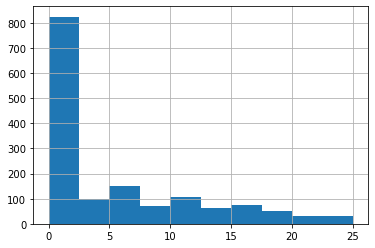

In [35]:
df["tau_it"].hist();

How does the average outcome by treament group change over time? - **Time series plot**

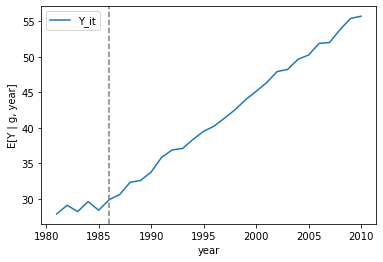

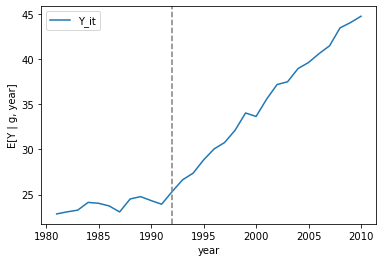

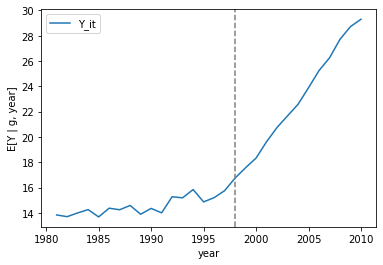

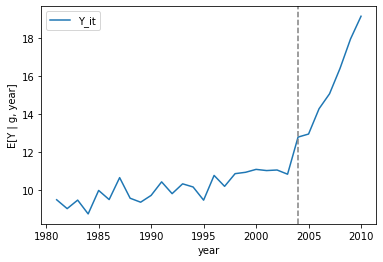

In [37]:
df_year = df_event_time = df.groupby(["group", "year"])["Y_it"].mean().reset_index()
for g in [1986, 1992, 1998, 2004]:
    df_g = df_year.loc[df_year["group"] == g, ["year", "Y_it"]]
    df_g.set_index("year", inplace=True)
    df_g.plot();
    plt.ylabel("E[Y | g, year]");
    plt.axvline(x=g, color='grey', linestyle='--');

How does the average outcome by treament group change over event-time?

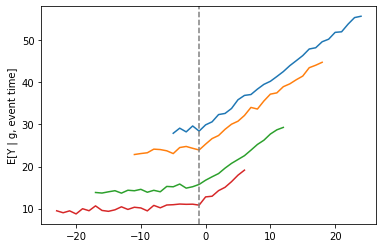

In [38]:
df_event_time = df.groupby(["group", "event_time"])["Y_it"].mean().reset_index()
for g in [1986, 1992, 1998, 2004]:
    df_g = df_event_time.loc[df_event_time["group"] == g, ["event_time", "Y_it"]]
    df_g.set_index("event_time", inplace=True)
    plt.plot(df_g);
    
plt.axvline(x=-1, color='grey', linestyle='--');
plt.ylabel("E[Y | g, event time]");

How does the treatment effect by treament group change over time?

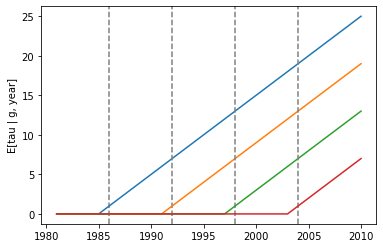

In [39]:
df_year = df.groupby(["group", "year"])["tau_it"].mean().reset_index()
for g in [1986, 1992, 1998, 2004]:
    df_g = df_year.loc[df_year["group"] == g, ["year", "tau_it"]]
    df_g.set_index("year", inplace=True)
    plt.axvline(x=g, color='grey', linestyle='--');
    plt.plot(df_g);
    
plt.ylabel("E[tau | g, year]");

How does the treatment effect by treament group change over event-time? 

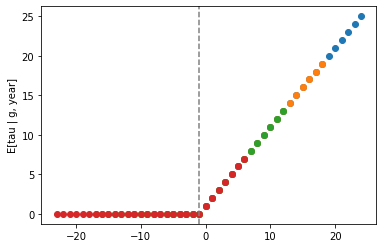

In [40]:
df_event_time = df.groupby(["group", "event_time"])["tau_it"].mean().reset_index()
for g in [1986, 1992, 1998, 2004]:
    df_g = df_event_time.loc[df_event_time["group"] == g, ["event_time", "tau_it"]]
    plt.scatter(df_g["event_time"], df_g["tau_it"]);
    
plt.axvline(x=-1, color='grey', linestyle='--');
plt.ylabel("E[tau | g, year]");

Note that this is the **"correct"** event-study plot. In empirical research, however, we do not know the real values of $\tau_{it}$, and we need to estimate them. 

We will drop all columns that would not be observed in real world, and give to another RP to analyze.

In [27]:
df = df[["state", "year", "group", "Y_it"]]
df

,state,year,group,Y_it
0,1,1981,1998,7.370562
1,2,1981,2004,6.127343
2,3,1981,1986,23.503703
3,4,1981,1998,9.833851
4,5,1981,1998,9.764046
...,...,...,...,...
1495,46,2010,2004,20.367255
1496,47,2010,2004,22.457552
1497,48,2010,1998,36.018287
1498,49,2010,1992,49.734808


## Read and Save DataFrames

We output this DataFrame to a csv file and give to Bob, another RP.

In [43]:
df.to_stata("data.dta")

Bob first read the data from the csv file:

In [45]:
df = pd.read_stata("data.dta")
df["event_time"] = df["year"] - df["group"]
df

,index,state,year,group,epsilon_it,event_time,tau_it,stupid_random_var,alpha_i,alpha_t,Y_it
0,0,1,1981,1998,0.369233,-17,0,2,0.172485,-1.089784,11.451935
1,1,2,1981,1992,0.085684,-11,0,2,2.172252,-0.943027,19.314909
2,2,3,1981,1998,-0.057824,-17,0,2,2.261259,-2.286531,11.916904
3,3,4,1981,2004,-0.150552,-23,0,2,0.342904,-2.075784,4.116568
4,4,5,1981,1998,-0.739261,-17,0,2,0.397788,-0.985390,10.673137
...,...,...,...,...,...,...,...,...,...,...,...
1495,1495,46,2010,1992,-0.797352,18,19,2,9.646873,1.162412,47.011933
1496,1496,47,2010,1992,0.256800,18,19,2,9.057451,2.016683,48.330934
1497,1497,48,2010,2004,-0.266350,6,7,2,9.770464,0.296650,22.800763
1498,1498,49,2010,1992,-0.584958,18,19,2,8.837267,1.581134,46.833443


## Preparing data for event-study

Bob proposes the classical event-study design:

$$Y_{it} = \alpha_i + \alpha_t + \gamma_{<-5} D_{i,t}^{< -5} + \sum_{k=-5,k\neq-1}^{5} \gamma_k D_{it}^k + \gamma_{>5} D_{i,t}^{>5} + \epsilon_{it},$$

where $D_{i,t}^k = \mathbf{1}[t-g_i = k].$ He starts by generating dummy variables.

In [30]:
df_reg = df.copy()

# Define dummies based on a condition using np.where()
df_reg["D_<-5"] = np.where(df_reg["event_time"] < -5, 1, 0)
df_reg["D_>5"] = np.where(df_reg["event_time"] > 5, 1, 0)

# Change any event-time outside of [-5, 5] to -1 as we will not create dummies for them.
df_reg["D"] = np.where(abs(df_reg["event_time"]) <= 5, df_reg["event_time"], -1)

# Get event-time dummies
df_reg = pd.get_dummies(df_reg, columns=["D"])

df_reg

,state,year,group,Y_it,event_time,D_<-5,D_>5,D_-5,D_-4,D_-3,D_-2,D_-1,D_0,D_1,D_2,D_3,D_4,D_5
0,1,1981,1998,7.370562,-17,1,0,0,0,0,0,1,0,0,0,0,0,0
1,2,1981,2004,6.127343,-23,1,0,0,0,0,0,1,0,0,0,0,0,0
2,3,1981,1986,23.503703,-5,0,0,1,0,0,0,0,0,0,0,0,0,0
3,4,1981,1998,9.833851,-17,1,0,0,0,0,0,1,0,0,0,0,0,0
4,5,1981,1998,9.764046,-17,1,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,46,2010,2004,20.367255,6,0,1,0,0,0,0,1,0,0,0,0,0,0
1496,47,2010,2004,22.457552,6,0,1,0,0,0,0,1,0,0,0,0,0,0
1497,48,2010,1998,36.018287,12,0,1,0,0,0,0,1,0,0,0,0,0,0
1498,49,2010,1992,49.734808,18,0,1,0,0,0,0,1,0,0,0,0,0,0


Construct year FEs and state FEs:

In [31]:
df_reg = pd.get_dummies(df_reg, columns=["state", "year"], drop_first=True)
df_reg

,group,Y_it,event_time,D_<-5,D_>5,D_-5,D_-4,D_-3,D_-2,D_-1,...,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010
0,1998,7.370562,-17,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2004,6.127343,-23,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1986,23.503703,-5,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1998,9.833851,-17,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1998,9.764046,-17,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2004,20.367255,6,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1496,2004,22.457552,6,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1497,1998,36.018287,12,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1498,1992,49.734808,18,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


Drop columns that will not appear in the regression:

In [32]:
df_reg.drop(columns=["D_-1", "event_time", "group"], inplace = True)
df_reg

,Y_it,D_<-5,D_>5,D_-5,D_-4,D_-3,D_-2,D_0,D_1,D_2,...,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010
0,7.370562,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6.127343,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,23.503703,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.833851,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.764046,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,20.367255,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1496,22.457552,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1497,36.018287,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1498,49.734808,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Now, Bob is ready to run the regression

In [33]:
Y = df_reg["Y_it"]
X = df_reg.drop(columns=["Y_it"])
X = sm.add_constant(X)

C:\Users\bmukhame\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [34]:
model = sm.OLS(Y, X).fit(cov_type='cluster', cov_kwds={'groups': df['state']}, use_t=True)
coeff = model.params
ci = model.conf_int(alpha=0.05, cols=None)

result = pd.concat([coeff, ci], axis=1)
result.columns = ["estimate", "lower", "upper"]
df_gamma = result.loc["D_-5": "D_5"].reset_index()
df_gamma["event_time"] = df_gamma["index"].apply(lambda x: int(x[2:]))
df_gamma.drop(columns=["index"], inplace=True)
df_gamma

,estimate,lower,upper,event_time
0,1.594962,0.900308,2.289616,-5
1,0.985000,0.151312,1.818689,-4
2,0.579628,-0.127721,1.286977,-3
3,0.311448,-0.520367,1.143263,-2
4,1.135496,0.311775,1.959218,0
5,1.087932,0.231671,1.944193,1
6,1.709441,0.823177,2.595706,2
7,1.817329,0.867186,2.767472,3
8,1.807050,0.844164,2.769935,4
9,2.686795,1.967659,3.405930,5


Recall that the coefficient at event time = -1 was omitted. Add it back to the DataFrame:

In [35]:
df_gamma = df_gamma.append({"estimate":0, "lower":0, "upper":0, "event_time": -1}, ignore_index=True)
df_gamma = df_gamma.sort_values(by=["event_time"])
df_gamma

,estimate,lower,upper,event_time
0,1.594962,0.900308,2.289616,-5
1,0.985000,0.151312,1.818689,-4
2,0.579628,-0.127721,1.286977,-3
3,0.311448,-0.520367,1.143263,-2
10,0.000000,0.000000,0.000000,-1
4,1.135496,0.311775,1.959218,0
5,1.087932,0.231671,1.944193,1
6,1.709441,0.823177,2.595706,2
7,1.817329,0.867186,2.767472,3
8,1.807050,0.844164,2.769935,4


Bob is now ready to make the event-study plot:

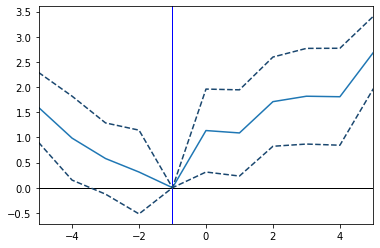

In [36]:
plt.plot(df_gamma["event_time"], df_gamma["estimate"])
plt.plot(df_gamma["event_time"], df_gamma["lower"], ls='--', color='#1a476f')
plt.plot(df_gamma["event_time"], df_gamma["upper"], ls='--', color='#1a476f')
plt.axhline(0, c='k', lw=1, zorder=-1);
plt.axvline(-1, c='b', lw=1, zorder=-1);
plt.xlim([-5,5]);

Based on the plot, Bob concludes that the effect of the policy 5 years after passage is less than 3. However, he is also debating about whether the parallel trend assumption might be violated, since there is a clear downward trend in the pre-period.

Now, let's show Bob the true treatment effects:

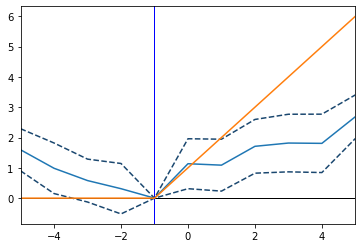

In [37]:
plt.plot(df_gamma["event_time"], df_gamma["estimate"])
plt.plot(df_gamma["event_time"], df_gamma["lower"], ls='--', color='#1a476f')
plt.plot(df_gamma["event_time"], df_gamma["upper"], ls='--', color='#1a476f')
plt.axhline(0, c='k', lw=1, zorder=-1);
plt.axvline(-1, c='b', lw=1, zorder=-1);
plt.xlim([-5,5]);

real_effects = df_g[abs(df_g["event_time"]) <= 5];
plt.plot(real_effects["event_time"], real_effects["tau_it"]);

This plot demonstrates the issues of a standard event-study design under staggered diff-in-diff setting:
- Negative weights might lead to biased estimates of treatment effects
- Non-significant pre-trend coefficients might not indicate that the parallel trend assumption holds.

## Reference

- CMSC 12100 by Borja Sotomayor
- ECON 31200 by Magne Mogstad.